# 01. Exploratory Data Analysis (EDA) and Feature Selection

Data analysis, with data pre-processing, and feature selection.

## 01. Imports and Settings

In [1]:
# Imports
from collections import Counter
from IPython.display import display
from libs.feature_selection import (
    get_iv_woe,
    get_high_corr_features_pairwise,
    select_feature_boruta
)  # feature_selection.py
from libs.plots import (
    show_boxplot,
    show_histogram,
    plot_correlation_matrix
)  # plots.py
from libs.pre_process import preprocess_network_data, drop_columns  # pre_process.py
from libs.utils import split_train_test, split_X_y  # utils.py

import lightgbm as lgb
import math
import pandas as pd
import warnings
import ydata_profiling


# Ignore warnings
warnings.filterwarnings("ignore")

# Pandas settings
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_colwidth", 150)  # Increase column width

# Default SEED
RANDOM_STATE = 42
# Default path
DATA_PATH = "data/"
REPORTS_PATH = "reports/"

## 02. Load and Pre-Process Data

In [2]:
# Load data
network_df = pd.read_csv(f"{DATA_PATH}raw/WSN_DS.csv")

# Pre-processing network data...
network_df, categorical_cols, numerical_cols = preprocess_network_data(network_df)
# Feature set
features = categorical_cols + numerical_cols

In [3]:
# Split into train/validation and test data
train_df, test_df = split_train_test(network_df, time_column="time", target_column="is_target", test_size=0.20)

## 03. Data Analysis

In [4]:
print("\nTarget Distribution:\n")
display(pd.DataFrame({"Count": train_df["is_target"].value_counts(),
                      "Percentage": train_df["is_target"].value_counts(normalize=True) * 100}))
print("\n")
# Extremely unbalanced, especially for class 3


Target Distribution:



,Count,Percentage
is_target,,
0,272053,92.40
1,11677,3.97
2,8039,2.73
3,2650,0.90


### 03.1. Numerical Columns



>> adv_r:



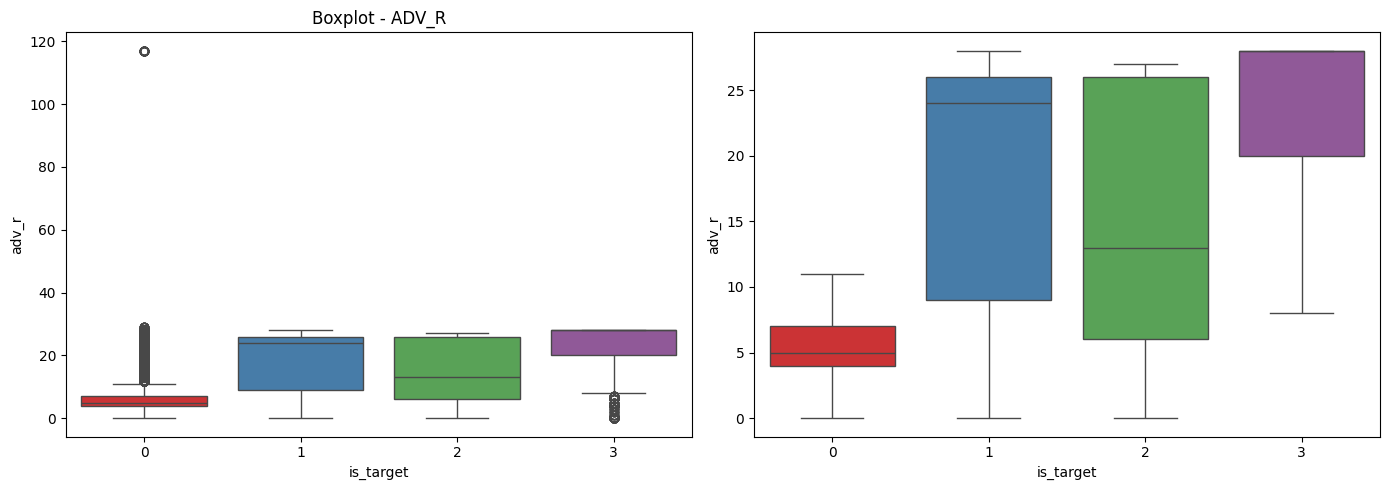

,count,mean,std,min,25%,50%,75%,90%,95%,max
is_target,,,,,,,,,,
0,272053.00,6.45,6.05,0.00,4.00,5.00,7.00,10.00,27.00,117.00
1,11677.00,17.76,9.44,0.00,9.00,24.00,26.00,26.00,27.00,28.00
2,8039.00,15.24,9.62,0.00,6.00,13.00,26.00,26.00,26.00,27.00
3,2650.00,23.40,7.56,0.00,20.00,28.00,28.00,28.00,28.00,28.00




>> adv_s:



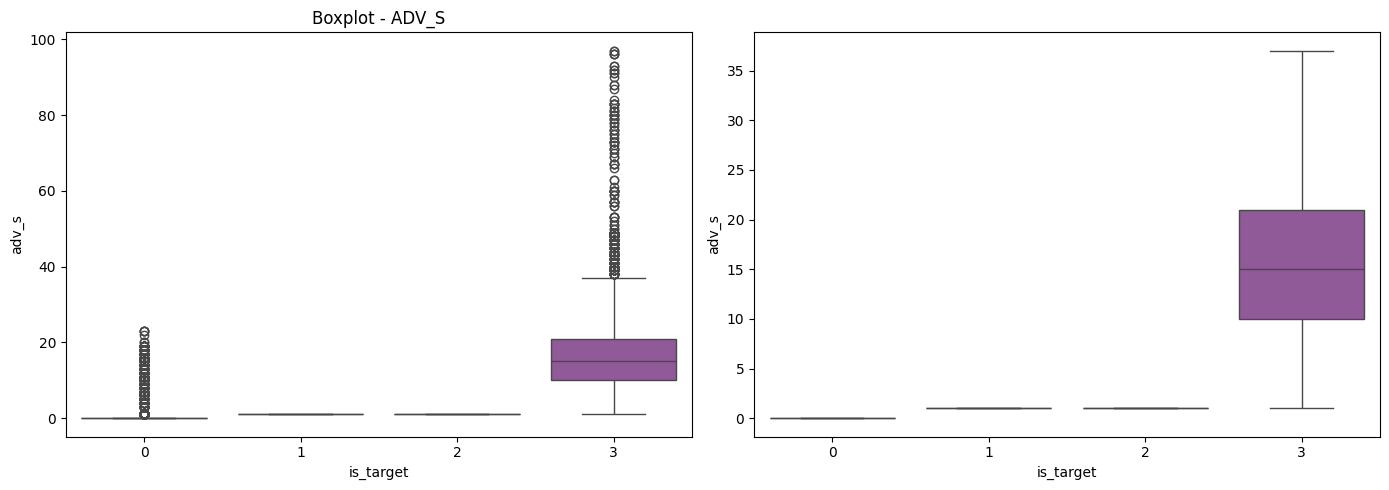

,count,mean,std,min,25%,50%,75%,90%,95%,max
is_target,,,,,,,,,,
0,272053.00,0.04,0.46,0.00,0.00,0.00,0.00,0.00,0.00,23.00
1,11677.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
2,8039.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
3,2650.00,17.88,13.82,1.00,10.00,15.00,21.00,33.00,46.00,97.00




>> data_r:



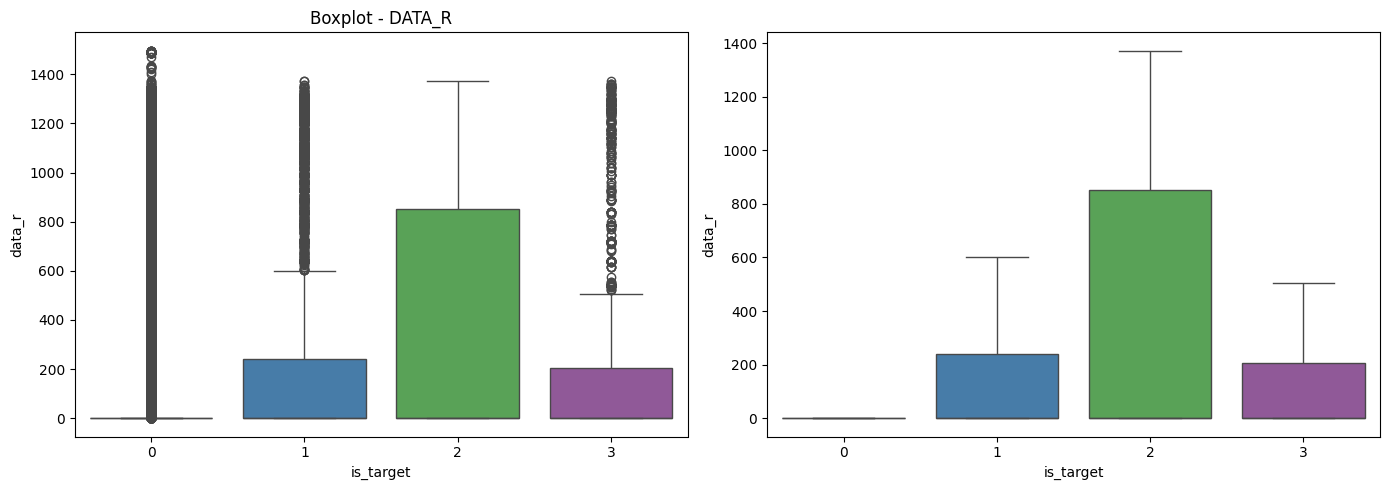

,count,mean,std,min,25%,50%,75%,90%,95%,max
is_target,,,,,,,,,,
0,272053.00,49.38,205.35,0.00,0.00,0.00,0.00,0.00,412.00,1496.00
1,11677.00,222.07,413.15,0.00,0.00,0.00,240.00,1057.20,1173.00,1372.00
2,8039.00,375.74,478.99,0.00,0.00,0.00,850.50,1155.00,1240.00,1372.00
3,2650.00,165.51,333.04,0.00,0.00,0.00,206.00,638.10,1126.10,1372.00




>> data_s:



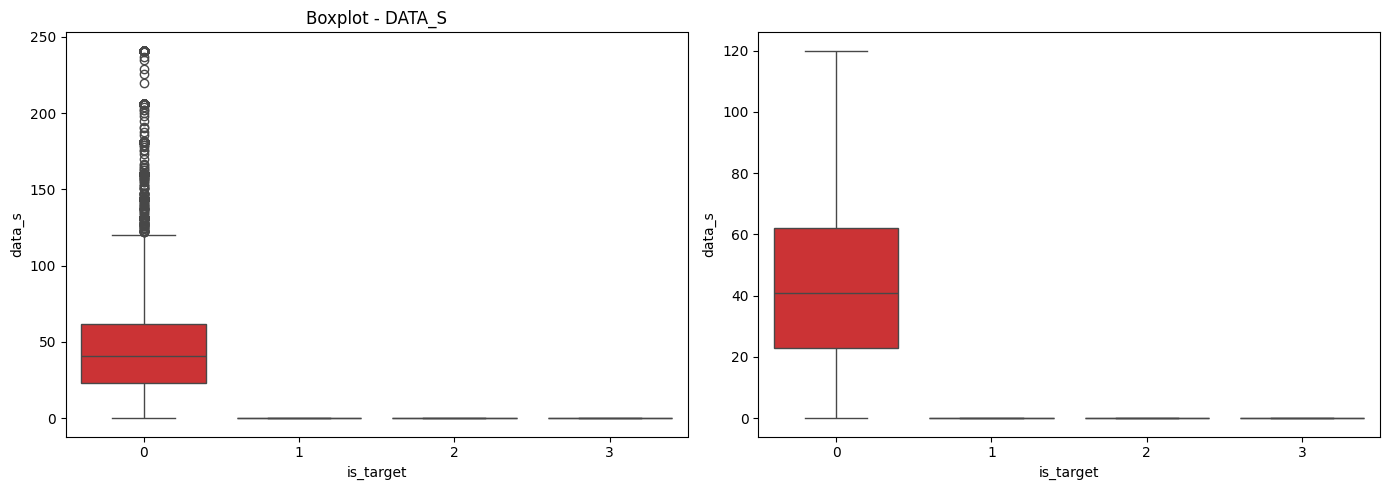

,count,mean,std,min,25%,50%,75%,90%,95%,max
is_target,,,,,,,,,,
0,272053.00,47.87,37.77,0.00,23.00,41.00,62.00,96.00,120.00,241.00
1,11677.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,8039.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,2650.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00




>> data_sent_to_bs:



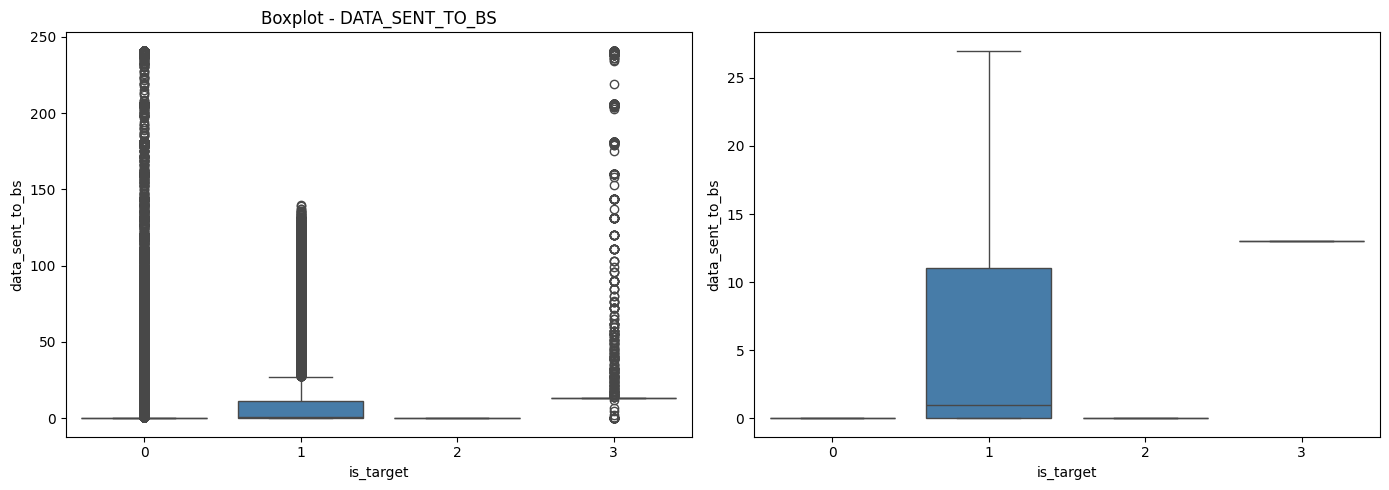

,count,mean,std,min,25%,50%,75%,90%,95%,max
is_target,,,,,,,,,,
0,272053.00,3.20,17.75,0.00,0.00,0.00,0.00,0.00,13.00,241.00
1,11677.00,14.88,29.17,0.00,0.00,1.00,11.00,59.00,89.00,140.00
2,8039.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,2650.00,36.37,60.19,0.00,13.00,13.00,13.00,153.50,206.00,241.00




>> dist_ch_to_bs:



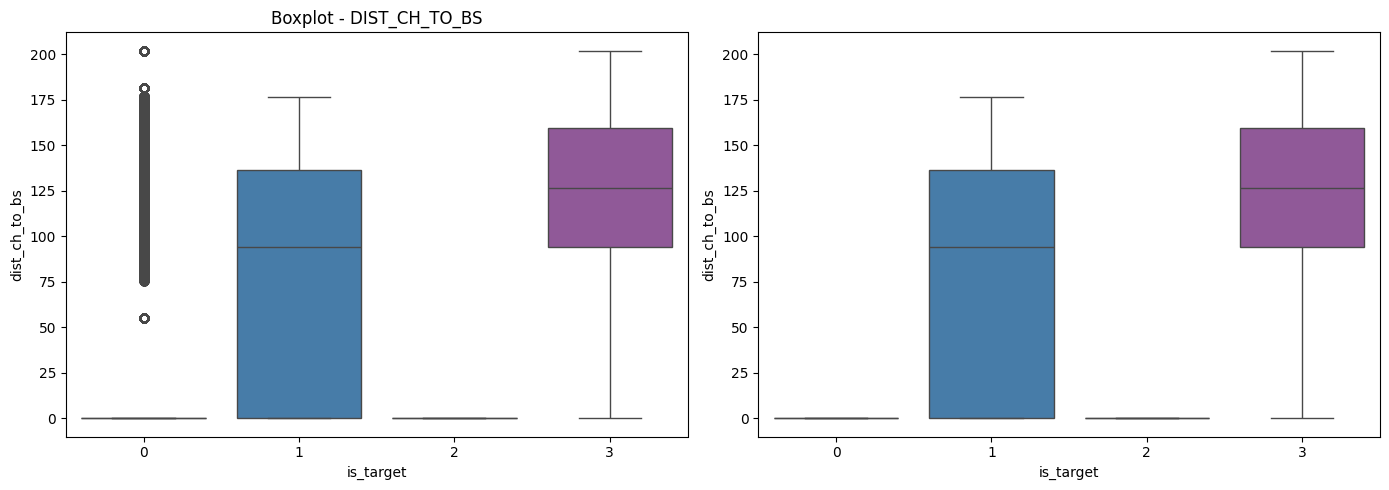

,count,mean,std,min,25%,50%,75%,90%,95%,max
is_target,,,,,,,,,,
0,272053.00,11.34,37.43,0.00,0.00,0.00,0.00,0.00,124.20,201.93
1,11677.00,79.27,64.15,0.00,0.00,94.18,136.26,156.97,163.77,176.62
2,8039.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,2650.00,127.13,41.13,0.00,94.11,126.72,159.31,181.31,201.93,201.93




>> dist_to_ch:



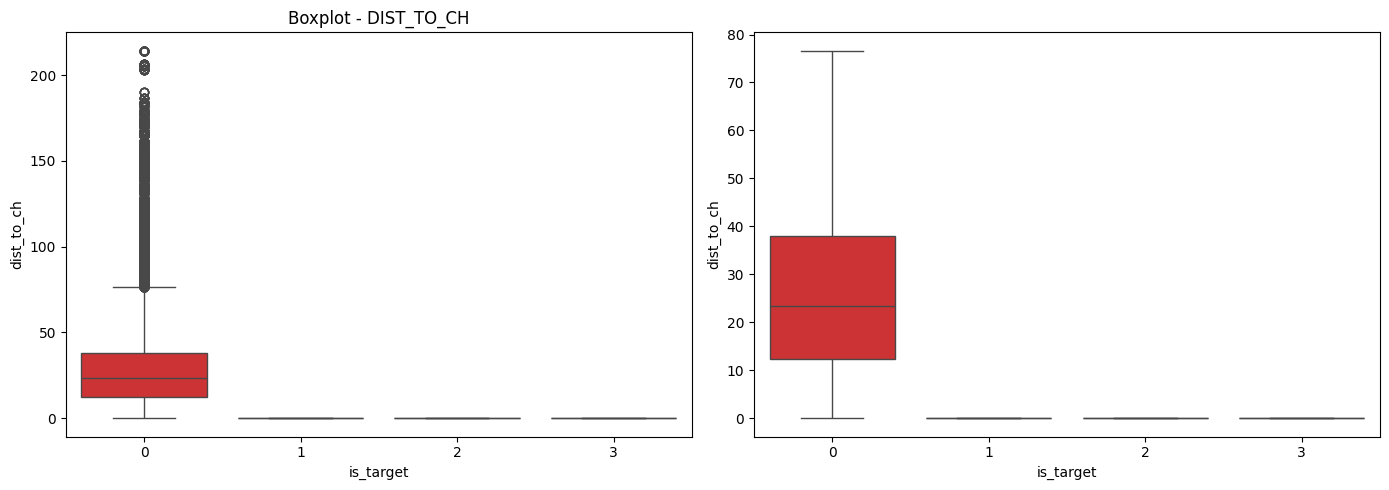

,count,mean,std,min,25%,50%,75%,90%,95%,max
is_target,,,,,,,,,,
0,272053.00,27.69,21.91,0.00,12.40,23.48,38.09,55.10,66.68,214.27
1,11677.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,8039.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,2650.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00




>> expaned_energy:



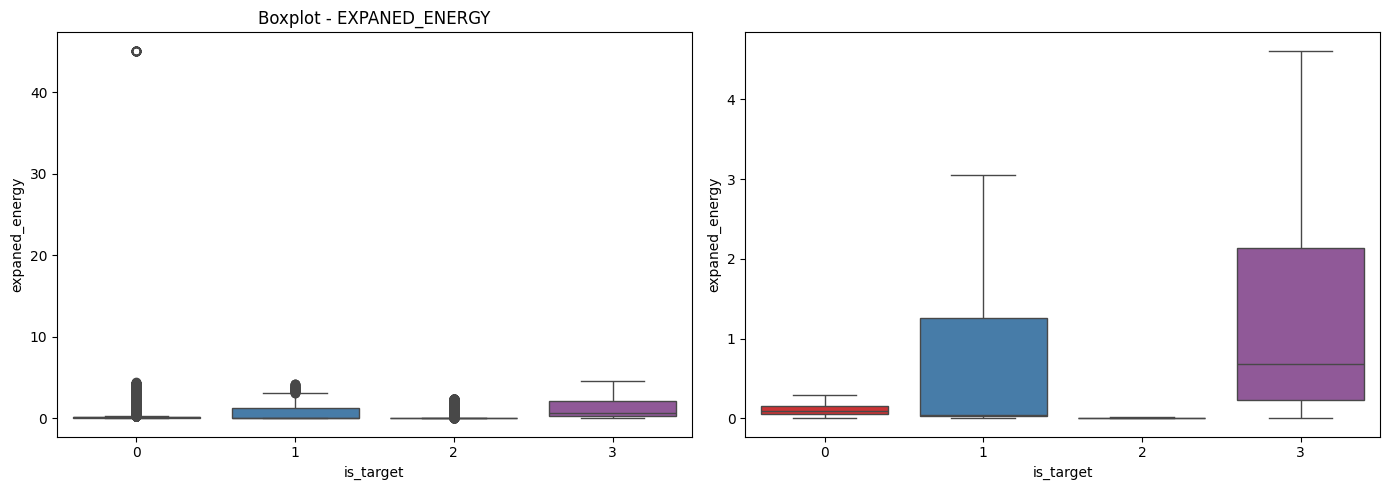

,count,mean,std,min,25%,50%,75%,90%,95%,max
is_target,,,,,,,,,,
0,272053.00,0.26,0.69,0.00,0.06,0.09,0.15,0.68,1.55,45.09
1,11677.00,0.59,0.92,0.00,0.02,0.04,1.25,2.21,2.31,4.17
2,8039.00,0.22,0.55,0.00,0.00,0.01,0.01,0.94,1.87,2.37
3,2650.00,1.20,1.09,0.01,0.23,0.67,2.14,2.83,3.25,4.61




>> join_r:



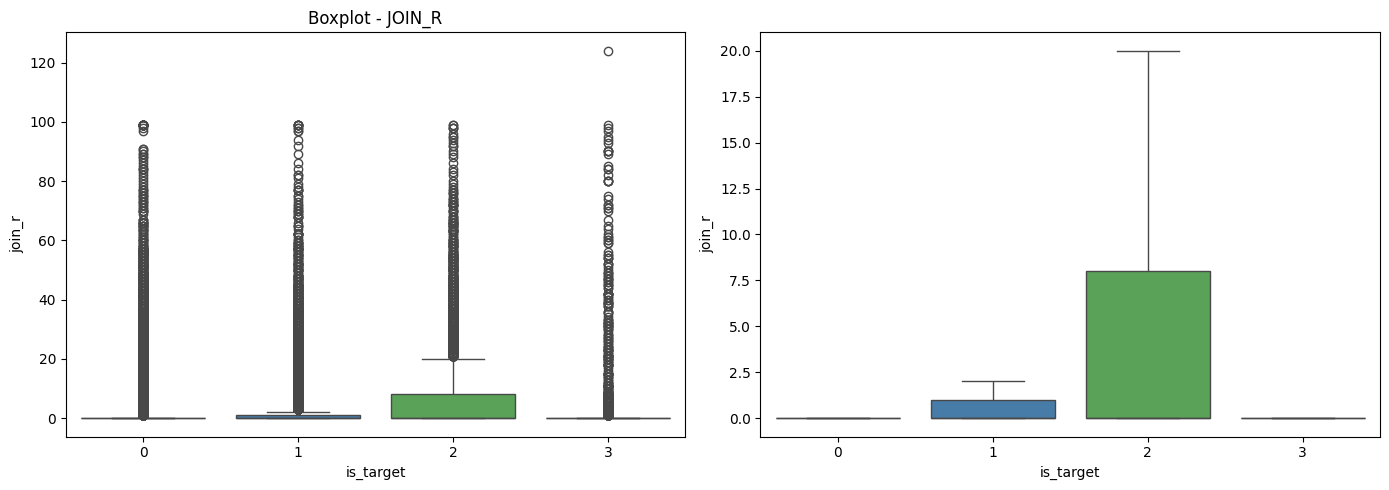

,count,mean,std,min,25%,50%,75%,90%,95%,max
is_target,,,,,,,,,,
0,272053.00,0.28,2.87,0.00,0.00,0.00,0.00,0.00,0.00,99.00
1,11677.00,3.77,9.93,0.00,0.00,0.00,1.00,14.00,24.00,99.00
2,8039.00,6.44,12.54,0.00,0.00,0.00,8.00,21.00,32.00,99.00
3,2650.00,3.09,11.75,0.00,0.00,0.00,0.00,4.00,21.00,124.00




>> rank:



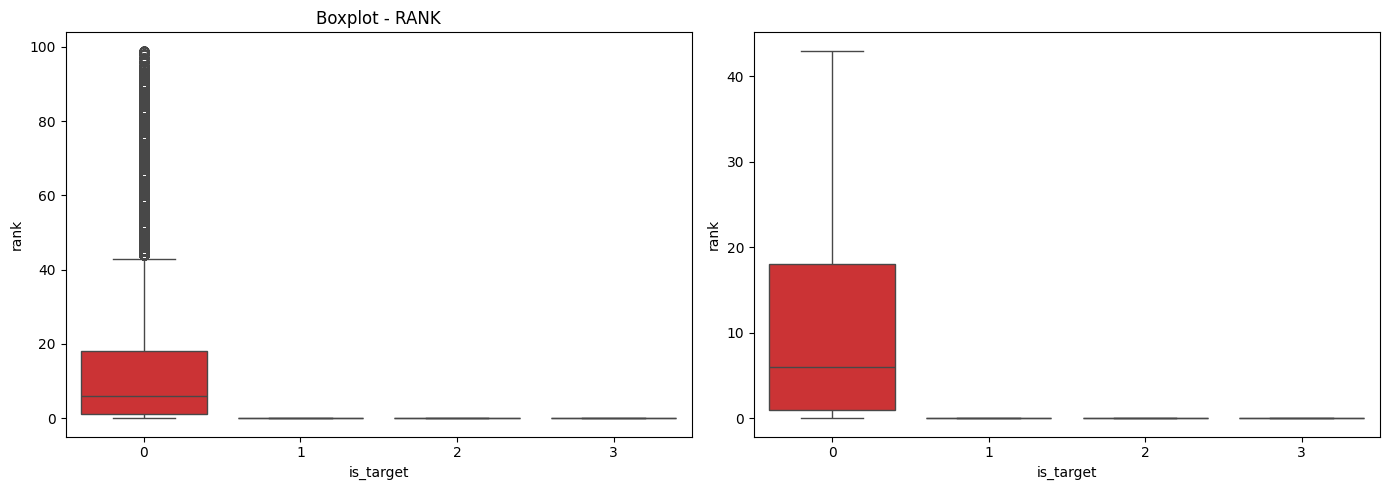

,count,mean,std,min,25%,50%,75%,90%,95%,max
is_target,,,,,,,,,,
0,272053.00,12.51,15.91,0.00,1.00,6.00,18.00,34.00,46.00,99.00
1,11677.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,8039.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,2650.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00




>> send_code:



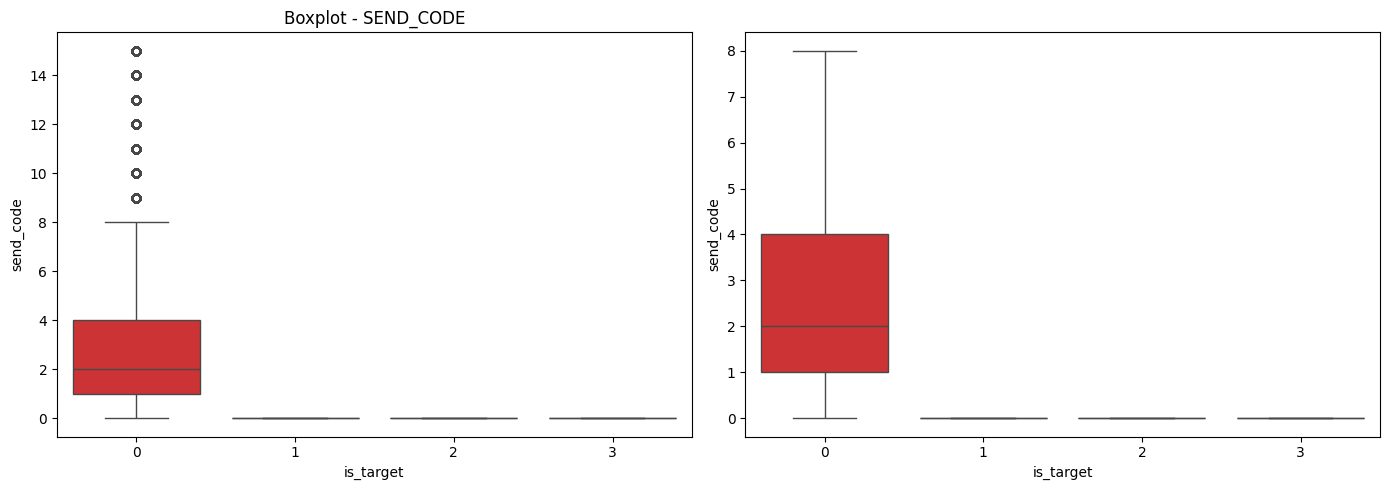

,count,mean,std,min,25%,50%,75%,90%,95%,max
is_target,,,,,,,,,,
0,272053.00,2.93,2.31,0.00,1.00,2.00,4.00,6.00,7.00,15.00
1,11677.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,8039.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,2650.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00




>> who_ch:



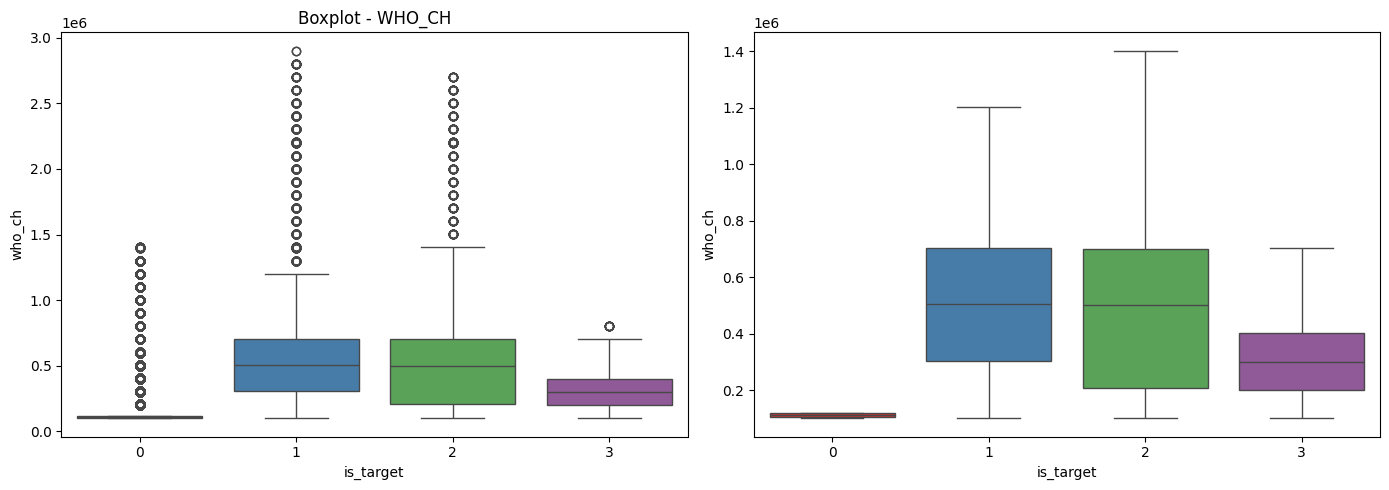

,count,mean,std,min,25%,50%,75%,90%,95%,max
is_target,,,,,,,,,,
0,272053.00,139068.63,87686.67,101000.00,106009.00,111100.00,119041.00,206058.00,210029.00,1402100.00
1,11677.00,583623.20,454904.67,101000.00,305100.00,505100.00,702100.00,1001031.00,1602100.00,2901100.00
2,8039.00,497205.34,385661.05,101000.00,208016.50,501069.00,701100.00,806100.00,905100.00,2701100.00
3,2650.00,304467.33,182321.39,101001.00,201009.00,301009.00,402034.00,601186.50,701034.00,801096.00


In [5]:
for col in numerical_cols:  # Numerical
    print(f"\n\n>> {col}:\n")
    show_boxplot(train_df, col, category="is_target")

### 03.2. Categorial Columns



>> join_s:



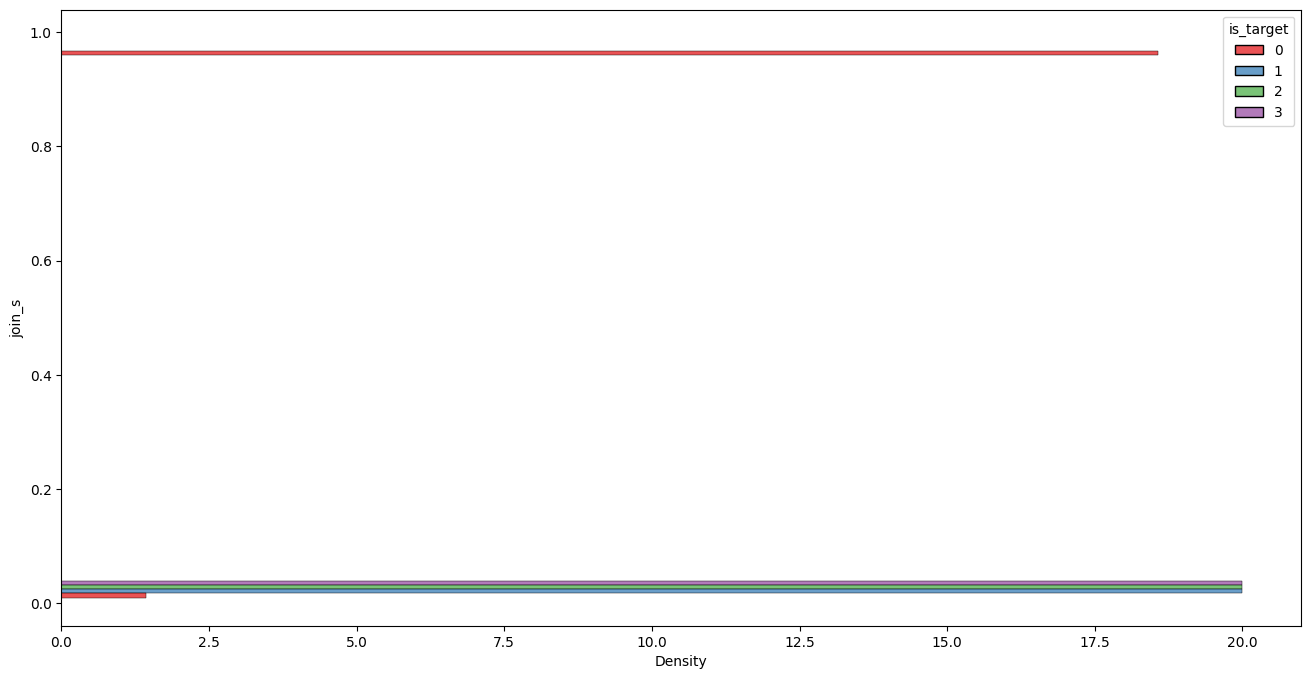

,count,mean,std,min,25%,50%,75%,90%,95%,max
is_target,,,,,,,,,,
0,272053.00,0.93,0.26,0.00,1.00,1.00,1.00,1.00,1.00,1.00
1,11677.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,8039.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,2650.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00




>> sch_s:



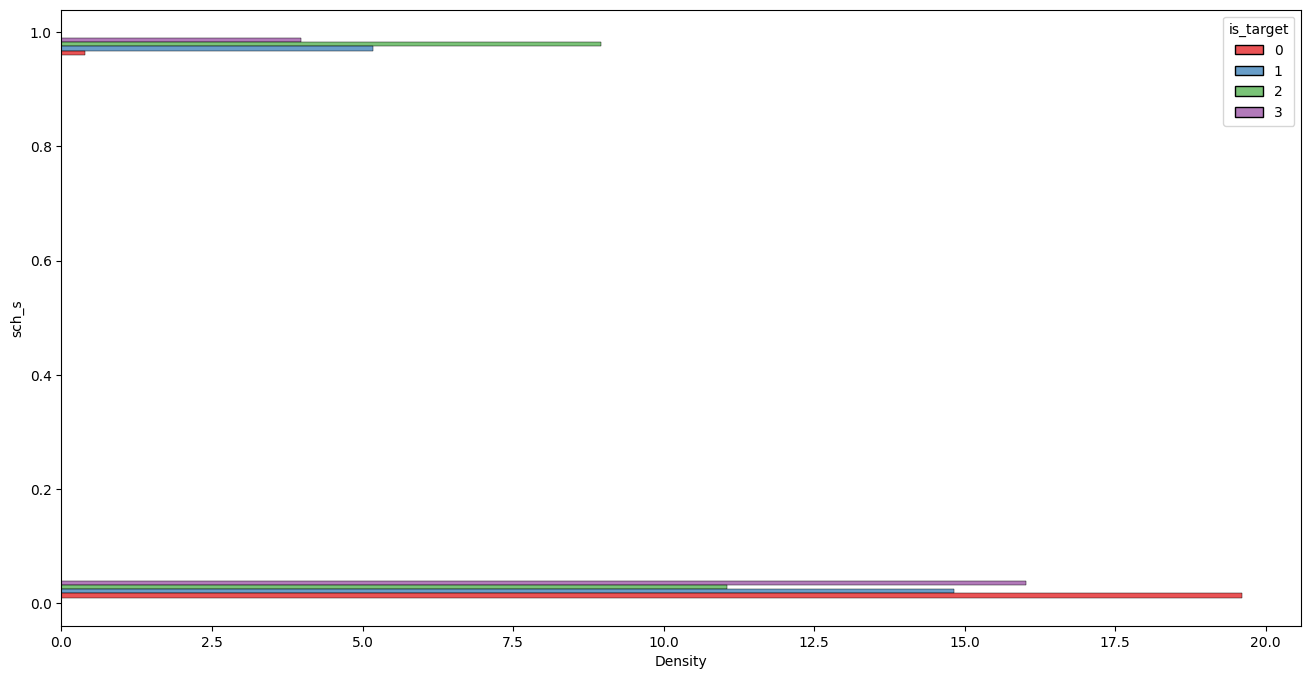

,count,mean,std,min,25%,50%,75%,90%,95%,max
is_target,,,,,,,,,,
0,272053.00,0.02,0.14,0.00,0.00,0.00,0.00,0.00,0.00,1.00
1,11677.00,0.26,0.44,0.00,0.00,0.00,1.00,1.00,1.00,1.00
2,8039.00,0.45,0.50,0.00,0.00,0.00,1.00,1.00,1.00,1.00
3,2650.00,0.20,0.40,0.00,0.00,0.00,0.00,1.00,1.00,1.00




>> sch_r:



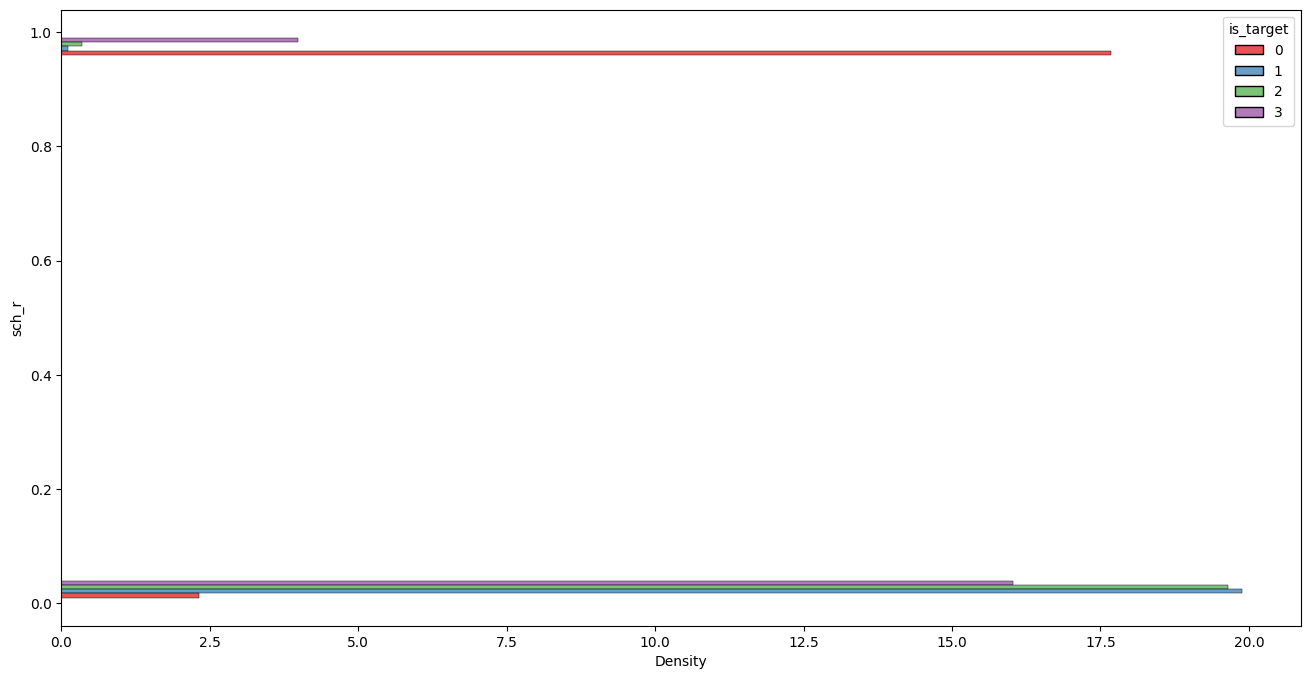

,count,mean,std,min,25%,50%,75%,90%,95%,max
is_target,,,,,,,,,,
0,272053.00,0.88,0.32,0.00,1.00,1.00,1.00,1.00,1.00,1.00
1,11677.00,0.01,0.07,0.00,0.00,0.00,0.00,0.00,0.00,1.00
2,8039.00,0.02,0.13,0.00,0.00,0.00,0.00,0.00,0.00,1.00
3,2650.00,0.20,0.40,0.00,0.00,0.00,0.00,1.00,1.00,1.00


In [6]:
for col in categorical_cols:  # Categorical
    print(f"\n\n>> {col}:\n")
    show_histogram(train_df, col, orient_h=False, describe=True, category="is_target")

### 03.3. Profile Report

In [7]:
# Generate profile report
report = train_df.profile_report(title="WSN-DS ― Training Data", html={"style": {"full_width": True}})
# Save report to file
report.to_file(f"{REPORTS_PATH}profile_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 04. Feature Selection

### 04.1. Information Value (IV)

In [8]:
# Calculate IV and WoE
iv, woe = get_iv_woe(train_df[numerical_cols + ["is_target"]], "is_target")
# Features sorting by IV
display(iv.sort_values(by="IV", ascending=False))
# Drop feature with IV < 0.02 (not useful)
train_df, numerical_cols, features, = drop_columns(
    train_df, numerical_cols, features, ["join_r"])

,Variable,IV
0,dist_to_ch,10.39
0,data_s,10.10
0,send_code,7.59
0,rank,7.29
0,who_ch,3.63
0,expaned_energy,3.28
0,adv_r,2.34
0,dist_ch_to_bs,0.62
0,data_sent_to_bs,0.44
0,adv_s,0.00


### 04.2. Correlation Matrix

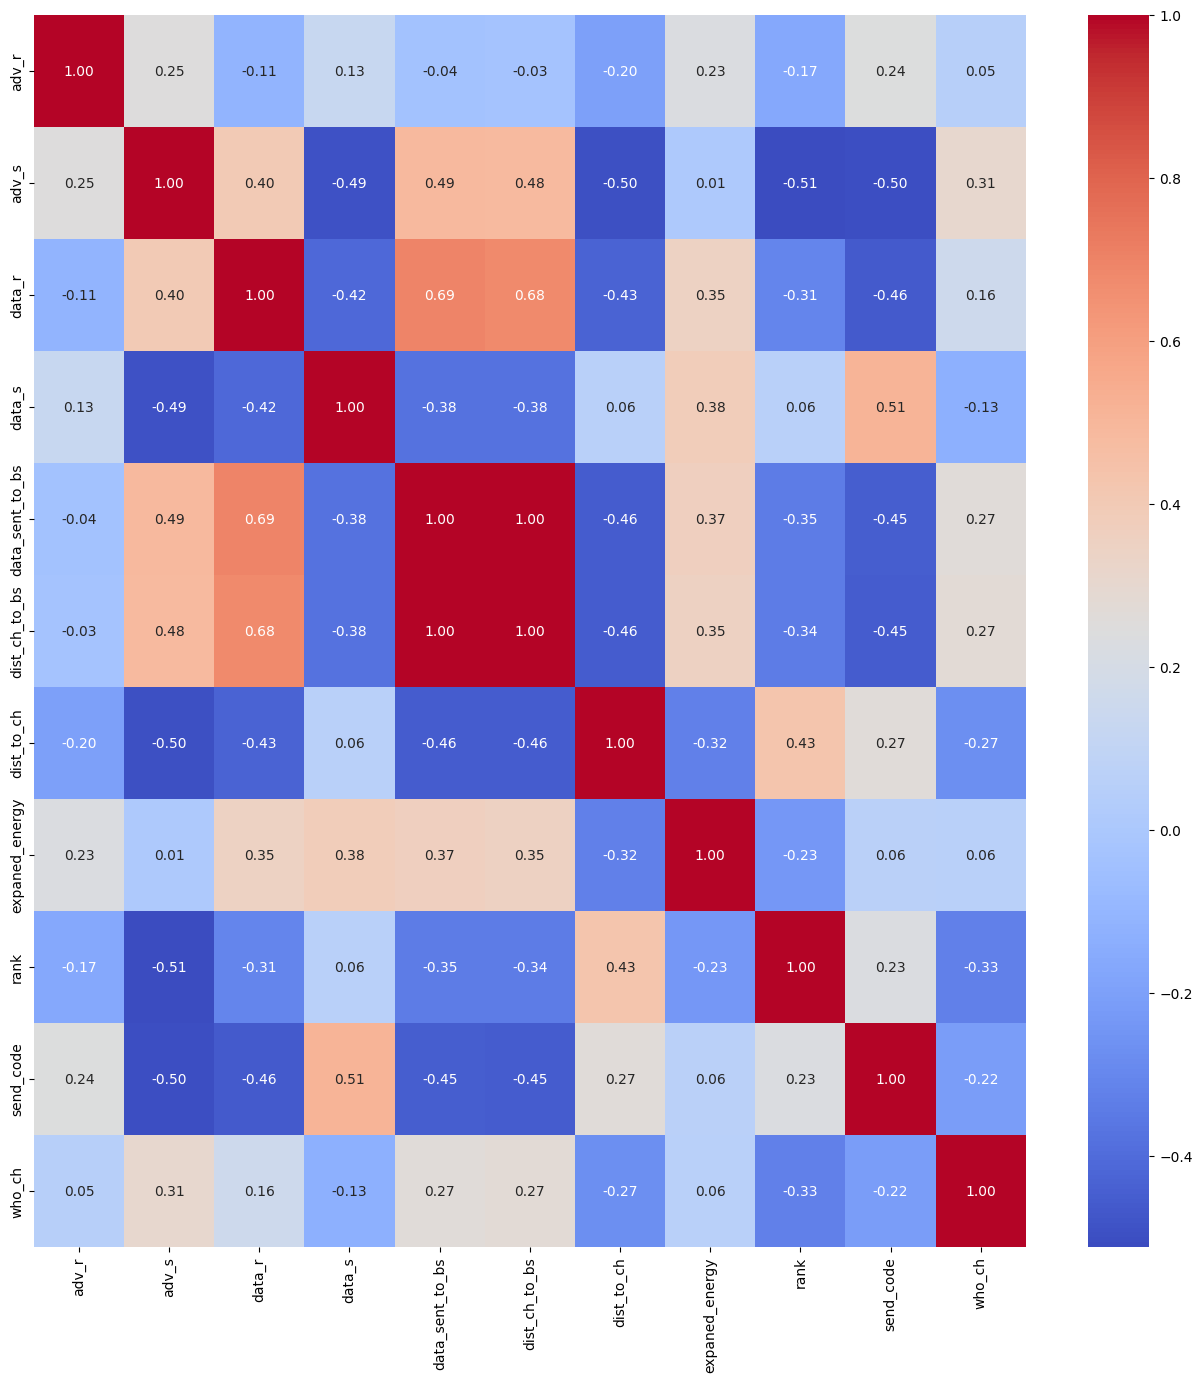

adv_r            adv_r           1.00
data_sent_to_bs  dist_ch_to_bs   1.00
adv_r            adv_s            NaN
dtype: float64

In [9]:
# Spearman correlation matrix
plot_correlation_matrix(train_df[numerical_cols], method="spearman")
get_high_corr_features_pairwise(train_df[numerical_cols], threshold=0.8, method="spearman")

In [10]:
# Drop one of the columns with a correlation greater than 0.80
train_df, numerical_cols, features, = drop_columns(
    train_df, numerical_cols, features, ["data_sent_to_bs"])

### 04.3. Boruta-SHAP

In [11]:
# Split into X and y
X, y = split_X_y(train_df, "is_target", ["time"])
# Map all target classes to 1
# Know which features differentiate non-targets and targets labels
y = y.map(lambda x: 1 if x != 0 else 0)

In [12]:
# Initialize the LightGBM model with the following hyperparameters:
### scale_pos_weight with Proportion of Classes
model = lgb.LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1,
                           scale_pos_weight=int(round(Counter(y)[0] / Counter(y)[1], 0)))

  0%|          | 0/100 [00:00<?, ?it/s]

6 attributes confirmed important: ['adv_s', 'expaned_energy', 'dist_ch_to_bs', 'adv_r', 'who_ch', 'data_r']
7 attributes confirmed unimportant: ['data_s', 'send_code', 'join_s', 'sch_r', 'sch_s', 'rank', 'dist_to_ch']
0 tentative attributes remains: []


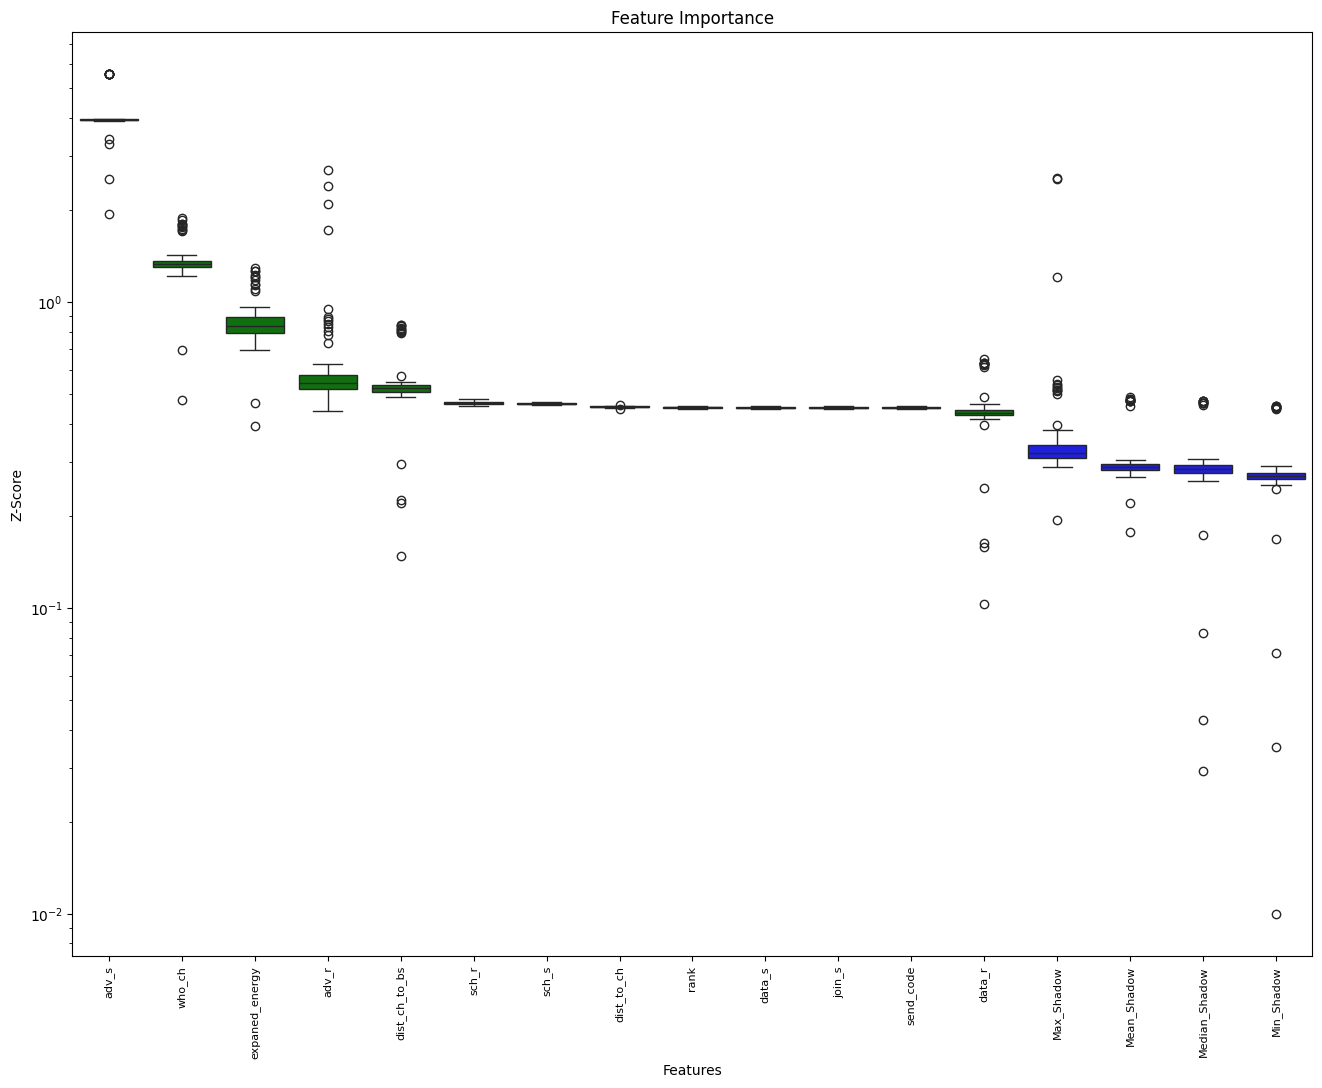

0 tentative features are now accepted: []
0 tentative features are now rejected: []


In [13]:
# Selecting features...
select_feature_boruta(X, y, model, n_trials=100)

## 05. Save Pre-Processed Data

In [14]:
# Save data after pre-processing and feature selection
train_df[features + ["is_target"]].to_csv(f"{DATA_PATH}train_data.csv", index=False)
test_df[features + ["is_target"]].to_csv(f"{DATA_PATH}test_data.csv", index=False)